In [80]:
#方策勾配法
#迷路ゲーム 人が上下左右に移動して右下のゴールまでたどり着くことが目的
#方策はある状態である行動を探る確率のこと　方策は関数，NN パラメータは方策に変換される値
#行動を繰り返して方策の更新を繰り返す　つまり最短な道を探す
#パッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

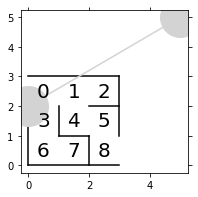

In [81]:
#迷路を作成　
fig=plt.figure(figsize=(3,3)) #3*3センチのグラフを生成

#壁 x，y座標まで指定した色で線を引く
plt.plot([0,3],[3,3],color='k')  
plt.plot([0,3],[0,0],color='k')  
plt.plot([0,0],[0,2],color='k')  
plt.plot([3,3],[1,3],color='k')  
plt.plot([1,1],[1,2],color='k')  
plt.plot([2,3],[2,2],color='k')  
plt.plot([2,1],[1,1],color='k')  
plt.plot([2,2],[0,1],color='k')  

#数字
for i in range(3):
  for j in range(3):
    plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center',va='center')

#円
circle,=plt.plot([0,5],[2,5],marker='o',color='#d3d3d3',markersize=40)

#目盛りと枠の非表示
plt.tick_params(axis='both', which='both',  bottom='off',  top='off',
                labelbottom='off', right='off', left='off', labelleft='off')
plt.box('off')

In [82]:
#パラメータの初期値の準備
theta_0=np.array([
                  [np.nan, 1 ,1, np.nan],  #0 上　右　下　左
                  [np.nan,1,1,1], #1
                  [np.nan,np.nan,np.nan,1], #2
                  [1,np.nan,1,np.nan], #3
                  [1,1,np.nan,np.nan], #4
                  [np.nan,np.nan,1,1], #5
                  [1,1,np.nan,np.nan], #6
                 [np.nan, np.nan, np.nan ,1]]) #7

In [83]:
#パラメータを方策に変換  ソフトマックス関数　合計値を1にする
def get_pi(theta):
  #ソフトマックス関数で変換
  [m,n]=theta.shape
  pi=np.zeros((m,n))
  exp_theta=np.exp(theta)
  for i in range(0,m):
    pi[i,:]=exp_theta[i,:] / np.nansum(exp_theta[i,:])
  pi=np.nan_to_num(pi)
  return pi

In [84]:
#パラメータの初期値を方策に変換
pi_0=get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [85]:
#方策に従って行動を取得
def get_a(pi,s):
  #方策の確立に従って行動を返す
  return np.random.choice([0,1,2,3],p=pi[s]) #pの確率分布に従って配列の要素をランダムに返す

In [86]:
#行動に従って次の状態を取得
def get_s_next(s,a):
  if a==0: #上
    return s-3
  elif a==1: #右
    return s+1
  elif a==2: #下
    return s+3
  elif a==3: #左
    return s-1

In [87]:
#1エピソードの実行
def play(pi):
  s=0 #状態
  s_a_history=[[0,np.nan]] #状態と行動の履歴

  #エピソード完了までループ
  while True:
    #方策に従って行動と次の状態の取得
    a=get_a(pi,s) #pの確率分布に従って配列の要素をランダムに返す値をaに代入

    #行動に従って次の状態を取得した値をs_nextに代入
    s_next=get_s_next(s,a)

    #履歴の更新 状態，行動のリスト
    s_a_history[-1][1]=a
    s_a_history.append([s_next,np.nan])

    #終了判定
    if s_next==8:
      break
    else:
      s=s_next
  return s_a_history

In [88]:
#1エピソードの実行と履歴の確認
s_a_history=play(pi_0)
print(s_a_history)
print('1エピソードのステップ数:{}'.format(len(s_a_history)+1))

[[0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 1], [7, 3], [6, 1], [7, 3], [6, 1], [7, 3], [6, 1], [7, 3], [6, 1], [7, 3], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 2], [3, 2], [6, 1], [7, 3], [6, 0], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 0], [0, 1], [1, 2], [4, 1], [5, 3], [4, 0], [1, 1], [2, 3], [1, 2], [4, 1], [5, 2], [8, nan]]
1エピソードのステップ数:48


In [89]:
#方策は現在の状態(位置)に応じて次の行動を決定する戦略のこと．これは方策の重みパラメータθを更新する
def update_theta(theta,pi,s_a_history):
  eta=0.1 #学習係数
  total=len(s_a_history)-1 #ゴールまでにかかったそうステップ数
  [s_count,a_count]=theta.shape #状態数，行動数

  #パラメータθの変化量の計算
  delta_theta=theta.copy()
  for i in range(0,s_count):
    for j in range(0,a_count):
      if not(np.isnan(theta[i,j])):
        #ある状態である行動を取る回数
        sa_ij=[sa for sa in s_a_history if sa==[i,j]]
        n_ij=len(sa_ij)

        #ある状態で何らかの行動を取る回数
        sa_i=[sa for sa in s_a_history if sa[0]==i]
        n_i=len(sa_i)

        #パラメータθの変化量
        delta_theta[i,j]=(n_ij+pi[i,j]*n_i)/total

    #パラメータθの更新
    return theta+eta*delta_theta

In [98]:
#エピソードを繰り返し実行して学習　方策の変化量が閾値以下になったら終了
stop_epsilon=10**-4 #閾値
theta=theta_0 #パラメータθ
pi=pi_0 #方策

#エピソードを繰り返し実行して学習
for episode in range(10000):
  #1エピソード実行して履歴取得
  s_a_history=play(pi)

  #パラメータθの更新
  theta=update_theta(theta,pi,s_a_history)

  #方策の更新
  pi_new=get_pi(theta)

  #方策の変化量
  pi_delta=np.sum(np.abs(pi_new-pi))
  pi=pi_new

  #出力
  print('エピソード:{}, ステップ:{},方策変化量: {:.4f}'.format(episode,len(s_a_history)-1,pi_delta))

  #終了判定
  if pi_delta<stop_epsilon: #方策の変化量が閾値以下
    break


エピソード:0, ステップ:26,方策変化量: 0.0019
エピソード:1, ステップ:126,方策変化量: 0.0036
エピソード:2, ステップ:40,方策変化量: 0.0013
エピソード:3, ステップ:6,方策変化量: 0.0083
エピソード:4, ステップ:174,方策変化量: 0.0011
エピソード:5, ステップ:120,方策変化量: 0.0029
エピソード:6, ステップ:28,方策変化量: 0.0035
エピソード:7, ステップ:10,方策変化量: 0.0050
エピソード:8, ステップ:30,方策変化量: 0.0066
エピソード:9, ステップ:12,方策変化量: 0.0042
エピソード:10, ステップ:80,方策変化量: 0.0007
エピソード:11, ステップ:16,方策変化量: 0.0031
エピソード:12, ステップ:40,方策変化量: 0.0012
エピソード:13, ステップ:28,方策変化量: 0.0018
エピソード:14, ステップ:72,方策変化量: 0.0028
エピソード:15, ステップ:12,方策変化量: 0.0000


In [91]:
#アニメーションの定期処理を行う関数
def animate(i): #iは何フレーム目かになる
  state=s_a_history[i][0]
  circle.set_data((state%3)+0.5,2.5-int(state/3))
  return circle

#アニメーションの表示
anim=animation.FuncAnimation(fig,animate,\
                             frames=len(s_a_history),interval=200,repeat=False)
HTML(anim.to_jshtml())
